# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.


### Optimization Metrics
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

-----
# I.  Define Environment

In [17]:
# Import for analyzing and reading data
import numpy as np
import pandas as pd
import sklearn
import scipy as sp
import scipy.stats as stats

# Import the visualization code
import myVisuals as vs
import util as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls

# Pretty display for notebooks
%matplotlib inline
from IPython.display import display

### The World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent_q1.py'
```

![Image](stills/grid.png)

### Rewards & Goal:<br>
The smartcab receives a **positive** reward for each
- succesfully completed trip
- action it executes successfully that obeys traffic rules

The smartcab receives a **negative** reward for each
- incorrect action
- action that violates traffic rules or causes an accident with another vehicle


#### Reward Scheme:<br>
- $R(s) = 2$ for a valid move headed toward the waypoint
- $R(s) = 1$ for a valid move but not the waypoint 
- $R(s) = -5$ for a minor violation
- $R(s) = -10$ for a major violation
- $R(s) = -20$ for a minor accident
- $R(s) = -40$ for a major accident

*Based on the rewards and penalties the smartcab receives, the self-driving agent implementation should learn an optimal policy for driving on the city roads while obeying traffic rules, avoiding accidents, and reaching passengers’ destinations in the allotted time*

#### Task:
The white cab has the task of picking up a passenger at a random location and dropping them off at a goal destination
- Pickup and dropoff location change every iteration and are assigned randomly
- Location and movement is defined using x, y coordinates on the grid

#### Definitions in Environment
- Actions A(s) = 4
    - Left, right, forward, none

<br>
- Classes
    - Environment
    - Inputs
        - Oncoming (4) none, forward, left, right
        - Left (4) none, forward, left, right
        - Right (4) none, forward, left, right
        - Light
    - Agent
        - Start
        - Location
        - Heading
    - Destination
        - (x, y)


In [34]:
%%HTML
<video width="100%" height="640" controls autoplay>
  <source src="stills/q1_vid.mov" type="video/mp4">
    Your browser does not support the video tag.
</video>

> ### My observations from initial run: 
- In the initial simulation, the smartcab does not move.
- As the lights change, the cab recieves rewards in different amounts.




### The Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

>### Flag Parameters in `agent.py`
**Example:**
``` 
env = Environment(verbose = True, num_dummies=10, grid_size=(10,10))
```
- _verbose_: Parameter true forces driving agent to use Q-learning
    + Because Q-learning variables are not set, verbose flag does not affect driving agent
- _num\_dummies_ : Discrete number of dummy agents
    + Changes the number of dummy agents in smartcab environment to 10
- _grid\_size_ : Discrete number of intersections
    + Changes the number of intersections in environment to 10 columns x 10 rows


>### `environment.py` functions
- When an agent performs an action the `act` function is called.


>### `sumulator.py` functions
- The `render_text()` function renders and displays trial data in the terminal/command prompt.
- The `render()` function renders and displays the simulation with a GUI.


>### `planner.py` functions
- The `next_waypoint()` function considers **East-West** direction _before_ **North-South**

-----
## I. Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


In [32]:
%%HTML
<video width="100%" height="640" controls autoplay>
  <source src="stills/basic_agent.mov" type="video/mp4">
    Your browser does not support the video tag.
</video>

1) Load data from a CSV file and save as a new dataframe `data`

In [2]:
# Read data from simulation without learning
try:
    data = pd.read_csv("logs/sim_no-learning-full.csv", header=0,
                    names=['trial', 'testing', 'epsilon', 'alpha', 'initial_deadline', 'final_deadline', 'net_reward', 'action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident', 'num_success']) 
    #                        index_col='trial')
    print "Data from simulation without learning read successfully!"
    training_data = data[data['testing'] == False]
    testing_data = data[data['testing'] == True]
    print "Simulation data has {} samples with {} features each.".format(*data.shape)
    print "Training data data has {} samples with {} features each.".format(*training_data.shape)
    print "Test data has {} samples with {} features each.".format(*testing_data.shape)
except:
    print "Error loading dataset. Check path."
        
# getLogData("logs/sim_no-learning-full.csv", data, "without learning")

Data from simulation without learning read successfully!
Similuation data has 30 samples with 13 features each.
Training data data has 20 samples with 13 features each.
Test data has 10 samples with 13 features each.


In [3]:
display(data.head(5))

,trial,testing,epsilon,alpha,initial_deadline,final_deadline,net_reward,action-legal,action-minor_violation,action-major_violation,action-minor_accident,action-major_accident,num_success
0,1,False,1.0,0.5,20,0,-158.532106,7,4,7,0,2,0
1,2,False,1.0,0.5,25,0,-90.700961,17,2,4,1,1,0
2,3,False,1.0,0.5,30,0,-43.372967,22,3,5,0,0,0
3,4,False,1.0,0.5,20,0,-128.569808,12,2,3,1,2,0
4,5,False,1.0,0.5,25,0,-164.913775,13,2,7,1,2,0


2) Create individual `action_data` data frame

In [4]:
action_data = testing_data[['action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident']].copy()
display(action_data.head())

,action-legal,action-minor_violation,action-major_violation,action-minor_accident,action-major_accident
20,19,4,4,1,2
21,15,2,6,1,1
22,11,3,2,1,3
23,14,2,1,1,2
24,11,4,4,1,0


3) Explore the data with scikit-learn

In [5]:
# Generate various sumary statistics
display(data.describe())

,trial,epsilon,alpha,initial_deadline,final_deadline,net_reward,action-legal,action-minor_violation,action-major_violation,action-minor_accident,action-major_accident,num_success
count,30.000000,30.0,30.0,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0
mean,8.833333,1.0,0.5,25.000000,0.0,-116.710786,15.166667,2.500000,5.200000,0.833333,1.300000,0.0
std,5.614534,0.0,0.0,5.085476,0.0,47.967870,4.177801,1.432384,2.340056,0.833908,1.087547,0.0
min,1.000000,1.0,0.5,20.000000,0.0,-229.516220,7.000000,0.000000,1.000000,0.000000,0.000000,0.0
25%,4.250000,1.0,0.5,20.000000,0.0,-140.192025,12.000000,2.000000,4.000000,0.000000,0.000000,0.0
50%,8.000000,1.0,0.5,25.000000,0.0,-114.910763,14.500000,2.000000,5.000000,1.000000,1.000000,0.0
75%,12.750000,1.0,0.5,30.000000,0.0,-85.946860,18.000000,3.000000,7.000000,1.000000,2.000000,0.0
max,20.000000,1.0,0.5,35.000000,0.0,-33.213800,23.000000,6.000000,11.000000,3.000000,4.000000,0.0


4) Display visual results from simulation

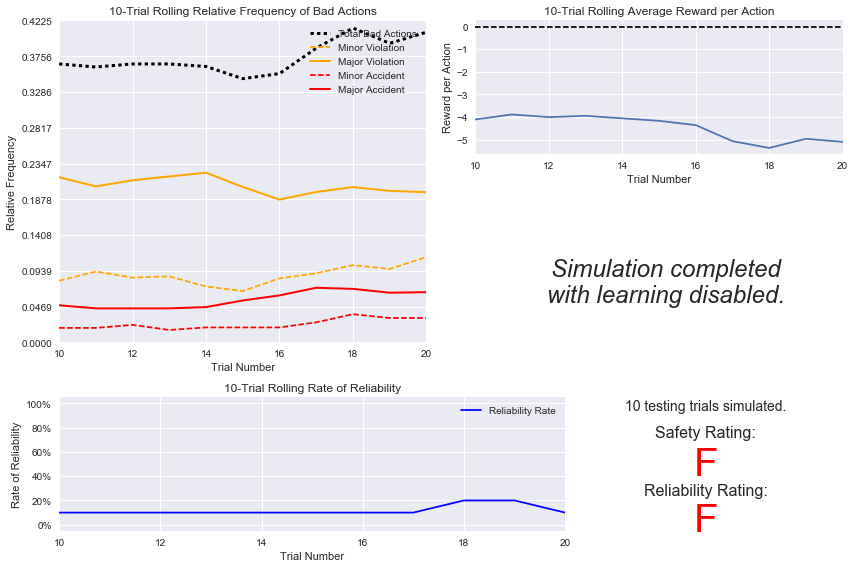

In [6]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

In [7]:
utils.getAvgActions(data)

Legal actions: 			455.0
Minor violations: 		75.0
Major violations: 		156.0
Minor accident: 		25.0
Legal actions: 			39.0

Agent makes legal actions-	60.67% of the time
Agent makes minor violations-	10.00% of the time
Agent makes major violations-	20.80% of the time
Agent has a minor accident-	3.33% of the time
Agent has a major accident-	5.20% of the time


## Frequency of Bad Decisions When Agent is Not Learning

[]

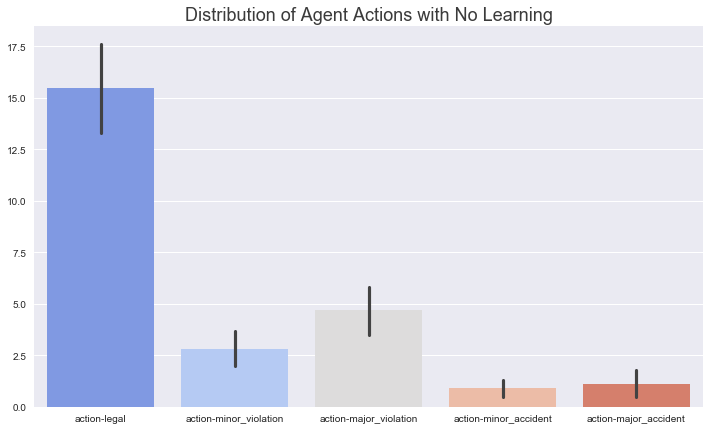

In [8]:
bar = sns.barplot(data=action_data, palette="coolwarm")
bar.figure.set_size_inches(12,7)
bar.axes.set_title('Distribution of Agent Actions with No Learning', fontsize=18, alpha=0.9)
bar.plot()

In [9]:
import IPython.display
url = "https://docs.google.com/spreadsheets/d/1FwA5i_sW4pWGhMbPKVUl5npduCET_mkiPQCFttSs81c/pubchart?oid=857693152&amp;format=interactive"
IPython.display.IFrame(url, width=681.6724798783807, height=500.5)

### The driving agent is making **bad decisions** 
>A bad decision can be defined by any type of violation or accident that the agent took. Over the initial 30 trials, when the agent was not learning, bad decisions were taken on average 47% of the time with an average 9% of those causing accidents. These numbers are not surprising. Without a policy implemented, the agent takes actions at random resulting a near 50-50 shot of making a “good action”. One thing to note is as the trials execute, the total number of bad actions increases.  

### Rate of Reliability (ROR)
>At this point, the rate of reliability (ROR) is 0. The agent neglected to reach its destination in any of the trials. Given the agent is driving randomly and a deadline is enforced, the low rate of reliability makes sense. With a larger sample of trials a few randomized successes can be deduced. Though we can expect more positive results with a larger sample of trials, the ROR would not change and we would not expect any significant change to the resulting outcomes.

### Negative Average Reward
>The agent receives an average reward of -105 over the sample of trials. As a considerately large negative number, we can deduce the agent is being penalized heavily for its actions.

### The Smartcab is *not* safe or reliable at this point
>At this point, the Smartcab would not be considered safe or reliable for passengers. Their is only a 7% margin between the likelihood of making a good action versus a bad action; meaning for every 17 “good” actions, 10 “bad” actions are bad. Or, to round up, statically after 2 “good” actions there is a significantly higher probability a “bad” action will be made. 

>According to the defined optimization metrics, the cab scored a grade “F” for safety and reliability. The Smartcab caused 37 major accidents in the sample and repeatedly failed to reach its destination gaining a ROR of 0%. 

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

### Agent Features Most Relevant for Learning *both* Safety and Efficiency
>- `'waypoint'`, is an important feature for **efficiency**
    - The smartcab relies on a sense of direction to get to its destination.
    - Arguably, this is where the most learning is made. Inputs are used to make effective decisions toward learning an *efficient* route.
    - As example, a right turn on red light may maximize time when it presents itself as an alternative but progressive action toward reaching the destination.
- `'inputs'`, are an import feature for **safety**
  - The inputs `'light', 'left'` and `'oncoming'` are all important to creating a policy
  - The smartcab relies on the inputs of its current state space to make smart safety decisions.
  - As example, the cab should know it is at a `'red'` light (`'light=red'`) and not to turn `'left'` or go '`forward'`.
  - `'right'` is **NOT** an necessary feature
      - Disregarding `'right'` reduces the state space by 24 and is of little value to a policy
      - As example, knowing the other aforementioned waypoints, a smartcab can enter enter a state with a red light. Knowing if another smartcab is coming from right is irrelevant to its decision to make a `'right'` turn on `'red'`. 
      - Another example, knowing the other aforementioned waypoints, a smartcab can enter a state with a green light. It only needs the knowledge of oncoming and left to judge its decision of a `'left', 'right'` or `'forward'` move.
- `'deadline'`, is **irrelevant** for our model
    - If a policy is correctly defined, deadline is just a bottleneck.
    - As example, if the state space is properly defined and waypoint is accurately tuned, the cab either will or will not reach the destination in the allotted time. The cab knowing that it is running short of time, should *not* disregard traffic laws to reach its destination within the deadline.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

```python
('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')```

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

Frequency: 

= 6! + 24!

Probability: 

= 1/(6! + 24!) = (approximately) 1.6117 E -24

**If our agent entered a state every second, it would take approximately 15 years and 3 months to definitively encounter and learn an optimal policy for this single state.**

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

>state space = 

>**waypoint** 
(`'forward', 'left', 'right'`) + **inputs** (light(`'green', 'red'`) + oncoming(`'none', 'forward', 'left', 'right'`) + left(`'none', 'forward', 'left', 'right'`))   =   waypoint (3) + inputs ( 2,  4,  4 )

>= 2(2 x 4!) 

>= 2(2 x 24) = 2(48)

>= 96 total states

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

### Estimating Q from Transitions: Q-Learning

In Q-learning a function $Q(s,a)$ represents **the maximum discounted future reward when an action ** $a$ ** is taken in state ** $s$ ** and optimizes rewards from thereon out.** A Q-Learner will train our agent to pick the best action at every state by choosing the realized maximum rewards. 

![agent-environment](https://deepsense.io/wp-content/uploads/2017/03/playing-atari-on-ram-with-deep-q-learning-Agent-Env-crop.png)<div style="text-align:right"><cite>[1]: Jake Bennett</cite></div>

##### Finding a policy and training the agent

$$\pi(s) = argmax_{a} Q(s,a)$$
A policy $\pi$ is be responsible for choosing actions. Policies use transition functions to place a reward value on the current state:

$$Q(s,a) = R(s) + \gamma \sum\limits_{s^\prime}  T(s,a,s^\prime) \underset{a^\prime}{max} (s^\prime,a^\prime)$$

Where,
- A $ transition $ (T) is $<s,a,r,s^\prime >$
- and a $reward$ (R) is the sum of the utility of sequences $\sum\limits_{t=0}^{\infty} R(S_{t}) = U(S_{0}, S_{1}, S{2}, \cdots)$ such that, $\sum\limits_{t=0}^{\infty} \gamma^{t}R_{max} = \frac{R_{max}}{1-\gamma} $

and the Q-learning rule is,


$${Q}(s,a) := {Q}(s,a) + \alpha(r + \gamma\underset{a'}{max} {Q}(s^\prime,a^\prime) - {Q}(s,a))$$

##### The Bellman equation

We learn the best move to make by iteratively finding the best move made from states we have entered. The **bellman equation ** is hence the the maximum future reward for the current state action pair _plus_ the following state action pair.

$$\hat{Q}(s,a) \xleftarrow{\color{Green}{\text{learning rate}}} \overbrace{\underbrace{r}_{\color{Blue}{reward}} + \underbrace{\gamma}_{\color{Blue}{discount}} \underbrace{\underset{a'}{max} \hat{Q}(s^\prime,a^\prime)}_{\color{Blue}{\text{utility of next state}}}}^{\color{Red}{\text{utility of state}}} $$

$$\hat{Q}(s,a) \xleftarrow{\alpha} r + \gamma \underset{a'}({max} \hat{Q}(s^\prime,a^\prime))$$

Because, our policy is undefined this is a **learning** scenario where transitions will be used to estimate our Q-Learning function (as opposed to applying value or policy iteration). The agent will balance exploration and exploitation to learn an optimal policy by observing states and learning the available actions and rewards, a transitional model. **In sum, our agent does NOT know state transition probabilities or rewards at this point.**  

In Q-Learning, the agent will only learn from going from one state to another via an action and realizing the reward. Similarly, transitions are only accumulated through training; taking multiple actions in a single state. 


-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: 
1. For every state the agent visits, create an entry in the Q-table for all state-action pairs available. 
2. When the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. 

Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```python
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

![decay](https://articles.wearepop.com/hs-fs/hubfs/images/_article/AI_Series/Images_Algorithm_pt2_1.jpg?t=1490647703999&width=666&name=Images_Algorithm_pt2_1.jpg)<div style="text-align:right"><cite>[2]: Jake Bennett</cite></div>

The image above shows how a decay function is used to iteratively refine the policy ($\pi$) through exploration and exploitation to the point at which it converges to an optimal policy. 

## Q-Learning-Algorithm

**function** Q-learning-agent (percept) **returns** an action
    
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**inputs:** _percept_
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;current state $s'$
        
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; reward signal $r'$
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**persistent:**
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q$, a table of action values indexed by state and action - initially zero
       
       
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$<s, a, r>$ the previous state, action, and reward - initially null
       



**if** Terminal ? $(s)$ then $Q[s, None] \leftarrow r' $

if $s$ is not null **then**

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;get valid action
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;do action
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;observe reward $r$ and new state $s'$
       
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update Q-table
     
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q[s,a] = Q[s,a] + \alpha(r + \gamma max_{a'}Q[s',a']-Q[s,a])$


$<s, a, r> \leftarrow s', argmax_{a'} f(Q[s', a'], N_{s,a}[s',a']), r'$

**return** $a$

In [31]:
%%HTML
<video width="100%" height="640" controls autoplay>
  <source src="stills/q_agent.mov" type="video/mp4">
    Your browser does not support the video tag.
</video>

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

#### Initial Q-Learning Agent
1) Load data from CSV file and save as new data frame

2) Create individual data frame for agent actions

3) Inspect agent actions

In [10]:
# Read data from simulation without learning
try:
    learning_data = pd.read_csv("logs/sim_default-learning-full.csv", header=0,
                    names=['trial', 'testing', 'epsilon', 'alpha', 'initial_deadline', 'final_deadline', 'net_reward', 'action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident', 'num_success']) 
    #                        index_col='trial')
    print "Data from simulation without learning read successfully!"
    default_training_data = learning_data[learning_data['testing'] == False]
    default_testing_data = learning_data[learning_data['testing'] == True]
    print "Similuation data has {} samples with {} features each.".format(*learning_data.shape)
    print "Training data data has {} samples with {} features each.".format(*default_training_data.shape)
    print "Test data has {} samples with {} features each.".format(*default_testing_data.shape)
except:
    print "Error loading dataset. Check path."
    
default_action_data = default_testing_data[['action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident']].copy()
display(default_action_data.describe())

Data from simulation without learning read successfully!
Similuation data has 30 samples with 13 features each.
Training data data has 20 samples with 13 features each.
Test data has 10 samples with 13 features each.


,action-legal,action-minor_violation,action-major_violation,action-minor_accident,action-major_accident
count,10.000000,10.0,10.0,10.0,10.0
mean,19.200000,0.0,0.0,0.0,0.0
std,4.894441,0.0,0.0,0.0,0.0
min,6.000000,0.0,0.0,0.0,0.0
25%,20.000000,0.0,0.0,0.0,0.0
50%,20.000000,0.0,0.0,0.0,0.0
75%,20.000000,0.0,0.0,0.0,0.0
max,25.000000,0.0,0.0,0.0,0.0


4) Display visual results from simulation and print simulation statistics

_*It is important to note that 20 training trials were conducted following 10 test trials._

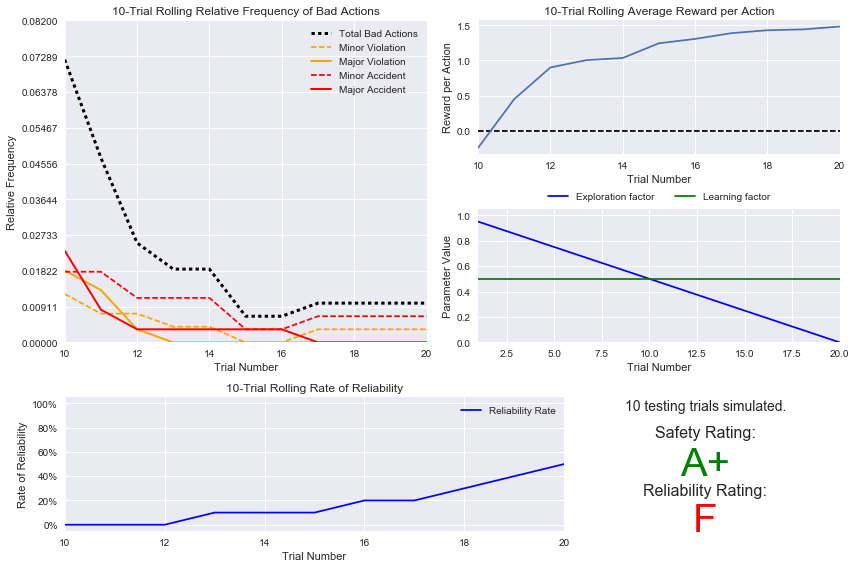

In [11]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

In [12]:
vs.print_stats('sim_default-learning.csv')

Total successful runs: 9/30
Rate of reliability: 40.00%
Average action: 96.96%
Average reward: 17.8098966351


## Initial Q-Learning Policy Analysis

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

### Frequence of Bad Decisions During Testing

[]

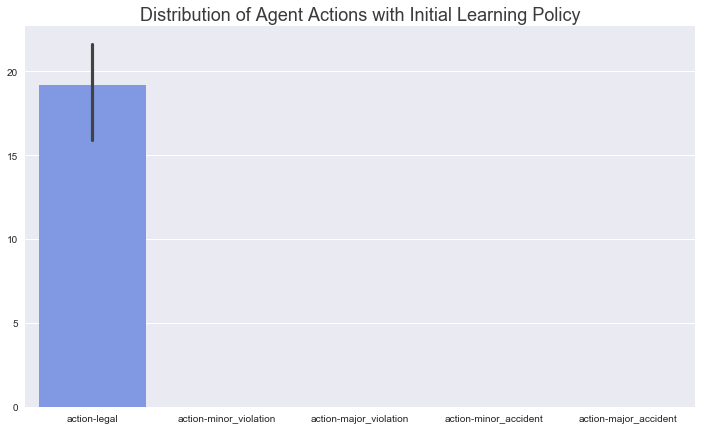

In [13]:
bar = sns.barplot(data=default_action_data, palette="coolwarm")
bar.figure.set_size_inches(12,7)
bar.axes.set_title('Distribution of Agent Actions with Initial Learning Policy', fontsize=18, alpha=0.9)
bar.plot()

### Similarities to Random Policy
>There are few similarities between the results of the basic driving agent and the default Q-Learning agent. One similarity is that the agent still takes random actions during training. This is part of the exploration vs. exploitation tradeoff. While the new policy doesn't act out randomness every action it does take random actions to continue learning. 


### Epsilon Tolerance
>The epsilon tolerance under this trial is 0.05. The number of training trials makes sense as after 20 trials and with an epsilon tolerance of 0.05, epsilon will decay to 0. The optimum number of training trials for some epsilon tolerance can be calculated by finding the quotient of 1 over the epsilon tolerance. 

$$\text{number of trials} = 1/0.05 = 20$$

### More "Good" Actions and Higher Rewards
>As visualized in the ‘10-Trial Rolling Relative Frequency of Bad Actions’, as the number of training trials increased the number of bad actions decreased. Similarly, as the number of training trials increased the average reward per action increased. This shows evidence of learning over the course of the trials. As the number of training trials increase, the agent makes better decisions and correspondingly receives higher rewards.

In [14]:
utils.getAvgActions(default_action_data)

Legal actions: 			192.0
Minor violations: 		0.0
Major violations: 		0.0
Minor accident: 		0.0
Legal actions: 			0.0

Agent makes legal actions-	100.00% of the time
Agent makes minor violations-	0.00% of the time
Agent makes major violations-	0.00% of the time
Agent has a minor accident-	0.00% of the time
Agent has a major accident-	0.00% of the time


### Not Reliable
> As visualized in the '10-Trial Rolling Rate of Reliability', the rate of reliability only showed growth near the 12th trial. In contrast to rewards and frequency of bad actions, the rate of reliability did show change immediately. The average rate of reliability for the default learning policy was 40%. This grew 40% from the initial random policy which accrued an average reliability rating of 0%.

### Summary of Policy Results
>The Q-Learning agent received a A+ safety rating and a F reliability rating. In contrast to the basic driving agent, the Q-Learning agent improved significantly in regards to safety. For safety, the agent committed no traffic violations and always chose the correct action. For reliability, the agent improved an overall 60% where an increase in reliability is apparent through the course of trials. 

>During testing, the frequency of _total bad actions_ decreased quickly until the 15 trial (approximately) where it stayed constant for the remainder of trials whereas the policies _reliability_ only began to climb gradually around the 12 trial. The average reward per action showed an increase from the beginning and leveled off around 18th trial. 

>Looking at the exploration factor of the policy, the noted items above follow the pattern of a linear decay function. As the learning rate stays the same, the exploration factor decreases towards 0 so more weight is put on what has been already "randomly" explored. 

>The simulation suggests, a lag in reliability; how often the agent reaches its destination in the allotted time. While rewards and total bad actions begin incrementing (and decrementing) immediately, reliability shows little to any growth until the first-quarter mark. This may suggest the policy isn't applying learned values quick enough due to high exploration (many random moves) and/or low weight on learned Q-values.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

### Optimize Parameters for Policy
1) Experiment with a variety of values for alpha and epsilon

2) To make this easier, I created an iterable method which logs the combinations for a variety of values

__Tradeoff__
Since there is a tradeoff between safety and reliability, I created an additional parameter `net_return_Saf-Rel` to the end of the log file. This parameter averages the values from `good_ratio` and `rate_reliability`. 

### Testing Parameters

To optimize my policy I decided to run trials on the combination of different decay functions and alpha/epsilon values. I tested the following decay functions and values:

 Model Number     | Equation $$ \epsilon = $$        |$\alpha $ limits 
-------------     | -------------------------------- | ------------------------------
 1                | $ a^t $                          | $$\textrm{ for }$$ $$0 < a < 1$$ 
 2                | $ \frac{1}{t^2}$                 |      
 3                | $ \epsilon ^ {-\alpha t}$        | $$\textrm{ for }$$ $$0 < a < 1$$
 4                | $\cos(at)$                       | $\quad\quad \textrm{ for } \quad\quad\quad 0 < a < 1 $


For alpha values of :
    
    `[0.01, 0.05, 0.2, 0.3, 0.73, 0.8, 0.96, 0.97, 0.989, 0.99, 0.991]`
    
and epsilon values of :
    
    `[0.039, 0.04, 0.043, 0.056, 0.049, 0.05, 0.1, 0.3]`                    

After testing different parameters and discount functions, I decided to further explore **model 1**. 

### Results from Model Testing

In [15]:
from plotly import tools

fig = py.get_figure("https://plot.ly/~hsherwood/125/")
# mod1 = tls.embed("https://plot.ly/~hsherwood/125/")
# mod2 = tls.embed("https://plot.ly/~hsherwood/127/")

py.iplot(fig)

> The heatmap suggests the strongest parameters lie at an __alpha of 0.95 and epsilon of 0.3__. 


*To check the visual findings, verify using describe() by calling the largest entry from `net_return_Saf-Rel`.*

In [30]:
%%HTML
<video width="100%" height="640" controls autoplay>
  <source src="stills/improved_agent.mov" type="video/mp4">
    Your browser does not support the video tag.
</video>

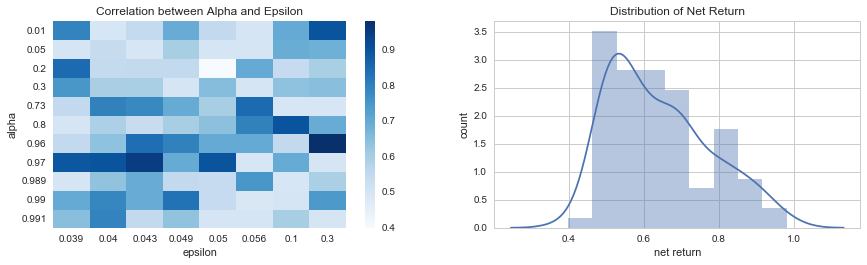

In [55]:
try:
    test_params = pd.read_csv("logs/improved_stats_all_model1.csv", header=0)
    #                        index_col='trial')
    with sns.axes_style("whitegrid"):
        plt.subplot(222)
        plt.tight_layout()
        hist = sns.distplot(test_params["net_return_Saf-Rel"])
        hist.figure.set_size_inches(12,7)
        plt.xlabel('net return')
        plt.ylabel('count')
        hist.set_title('Distribution of Net Return')
        
    with sns.axes_style("whitegrid"):
        copy = test_params[['alpha', 'epsilon', 'net_return_Saf-Rel']].copy()
        df = copy.pivot("alpha", "epsilon", "net_return_Saf-Rel")
        plt.subplot(221)
        hmap = sns.heatmap(df, cmap="Blues")
        hmap.figure.set_size_inches(12,7)
        hmap.set_title('Correlation between Alpha and Epsilon')
    
except:
    print "Error loading dataset. Check path."



In [18]:
df.describe()
test_params.loc[test_params['net_return_Saf-Rel'].idxmax()]

alpha                  0.960000
epsilon                0.300000
num_trials            10.000000
num_success           10.000000
good_ratio             0.961240
rate_reliability       1.000000
avg_reward            15.802201
net_return_Saf-Rel     0.980620
Name: 55, dtype: float64

### Improved Q-Learning Agent

1) Set alpha and epsilon parameters from findings

2) Load data from CSV file and save as new data frame

3) Create individual data frame for agent actions

4) Inspect agent actions


In [19]:
# Read data from simulation without learning
try:
    improved_data = pd.read_csv("logs/sim_improved-learning-full.csv", header=0,
                    names=['trial', 'testing', 'epsilon', 'alpha', 'initial_deadline', 'final_deadline', 'net_reward', 'action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident', 'num_success']) 
    #                        index_col='trial')
    print "Data from simulation without learning read successfully!"
    improved_training_data = improved_data[improved_data['testing'] == False]
    improved_testing_data = improved_data[improved_data['testing'] == True]
    print "Similuation data has {} samples with {} features each.".format(*improved_data.shape)
    print "Training data data has {} samples with {} features each.".format(*improved_training_data.shape)
    print "Test data has {} samples with {} features each.".format(*improved_testing_data.shape)
except:
    print "Error loading dataset. Check path."

improved_action_data = improved_testing_data[['action-legal', 'action-minor_violation', 'action-major_violation', 'action-minor_accident', 'action-major_accident']].copy()
display(improved_action_data.describe())

Data from simulation without learning read successfully!
Similuation data has 70 samples with 13 features each.
Training data data has 20 samples with 13 features each.
Test data has 50 samples with 13 features each.


,action-legal,action-minor_violation,action-major_violation,action-minor_accident,action-major_accident
count,50.000000,50.0,50.0,50.000000,50.0
mean,14.620000,0.0,0.0,0.300000,0.0
std,5.623892,0.0,0.0,0.614452,0.0
min,6.000000,0.0,0.0,0.000000,0.0
25%,11.000000,0.0,0.0,0.000000,0.0
50%,15.000000,0.0,0.0,0.000000,0.0
75%,18.000000,0.0,0.0,0.000000,0.0
max,30.000000,0.0,0.0,2.000000,0.0


In [20]:
utils.getAvgActions(improved_action_data)

Legal actions: 			731.0
Minor violations: 		0.0
Major violations: 		0.0
Minor accident: 		15.0
Legal actions: 			0.0

Agent makes legal actions-	97.99% of the time
Agent makes minor violations-	0.00% of the time
Agent makes major violations-	0.00% of the time
Agent has a minor accident-	2.01% of the time
Agent has a major accident-	0.00% of the time


5) Display visual results from simulation and print simulation statistics

*It is important to note that 74 training trials were conducted followed by 10 test trials.*

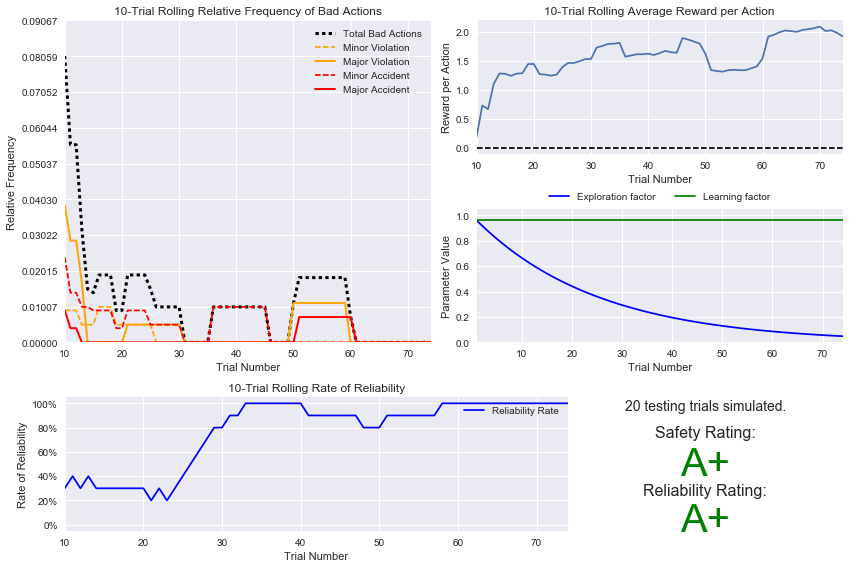

In [21]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
import visuals
vs.plot_trials('sim_improved-learning.csv')

In [22]:
vs.print_stats('sim_improved-learning.csv')

Total successful runs: 76/94
Rate of reliability: 100.00%
Average action: 98.18%
Average reward: 19.5344377427


## Improved Q-Learning Policy Analysis

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

### Decay Function: $\epsilon = \alpha^t$
> After testing a variety of decay functions, I went with an exponential decay function. The reason being that with the parameters I tested, this decay function yielded high results while minimizing the number of training trials. With my final parameters $\alpha = 0.3$ and $\epsilon = 0.96$ the function ran approximately **74 training trials** before reaching +0.05 within 0.0.


### Epsilon-tolerance and Alpha
> The improved policy has an initial **learning rate** of $\alpha = 0.3$. This is lower than the learning rate ($\alpha = 0.5$) of the two initial models. Since the rate is lower, the new policy is initially putting less value on newly learned Q-values. The initial **exploration rate** of the policy is $\epsilon = 0.96$ with an tolerance of $\epsilon_\text{ tolerance} = 0.05$. The exploration rate is is minimally lower than the initial two models which suggests the policy makes fewer *initial* random moves. 


### Improvement from Previous Policies


| Evaluation | No Learning  | Initial Learning: $$ \epsilon -= 0.05 $$  | Improved Learning: $$\epsilon = \alpha^t $$|
|----------- |------------- | ----------------------------------------- | -------------------------------------------|
| RoR        |  0.00%       | 40.00%                                    | 100.0% |
| Safety     |  60.67%      | 96.96%                                    | 98.14% |
| Average Reward | -114.91  | 17.81                                     | 22.54  |

> - From no learning to the initial learning, the rate of reliability **improved 40%**, the safety rating **improved 49.45%**, and the average reward **improved 115.5%**. The *average improvement was 68.32%*. 
- From initial learning to improved learning, the rate of reliability **improved 150%**, the safety rating **improved 1.22%**, and the average reward **improved 26.56%**. The *average improvement was 59.26*.
- From no learning to improved learning, the rate of reliability **improved 100%**, the safety rating **improved 61.76%**, and the average reward **improved 119.62%**. The *average improvement was 93.76*.

> There was considerable learning between no learning, improved learning, and the improved learner. While the growth rate slowed, ach forward step showed signs of learning an optimum policy and growth cannot be exponential in this case.

### Safety and Reliability Ratings

> The smartcab under an improved learning policy scored "A+" in both safety and reliability. The final scores for these ratings were at 100% in rate of reliability and 98.14% in safety. The metrics here show a strong policy, that I am satisfied with.

### Distribution of Agent Actions Among Different Policies

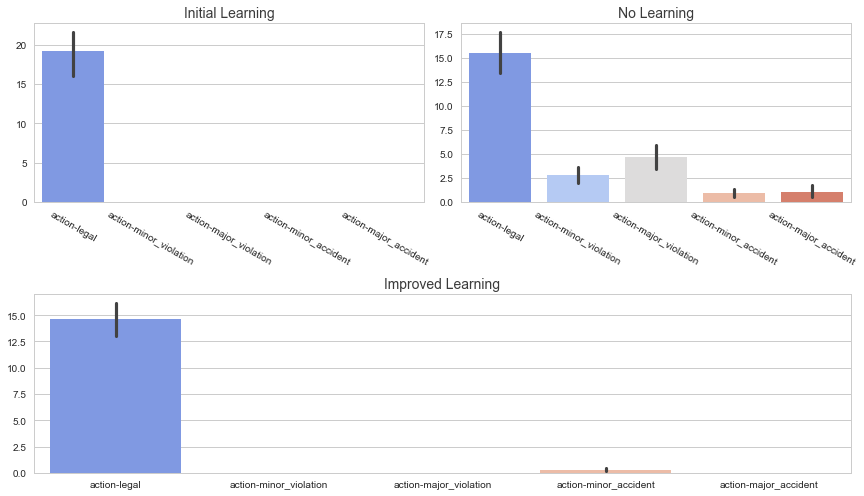

In [23]:
# Improved Learning
with sns.axes_style("whitegrid"):
    plt.subplot(212)
    plt.tight_layout()
    mod1 = sns.barplot(data=improved_action_data, palette="coolwarm")
    mod1.figure.set_size_inches(12,7)
    mod1.axes.set_title('Improved Learning', fontsize=14, alpha=0.9)

# Default
with sns.axes_style("whitegrid"):
    plt.subplot(221)
    plt.tight_layout()
    plt.xticks(rotation=330)
    mod2 = sns.barplot(data=default_action_data, palette="coolwarm")
    mod2.figure.set_size_inches(12,7)
    mod2.axes.set_title('Initial Learning', fontsize=14, alpha=0.9)
    

# No learning
with sns.axes_style("whitegrid"):
    plt.subplot(222)
    plt.tight_layout()
    plt.xticks(rotation=330)
    mod2 = sns.barplot(data=action_data, palette="coolwarm")
    mod2.figure.set_size_inches(12,7)
    mod2.axes.set_title('No Learning', fontsize=14, alpha=0.9)

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

### Optimal Policy: 
A state is defined by the tuple `'waypoint', inputs['light], inputs['oncoming']`.

>**Example 1:** The cab is at a green light and wants to head left. In the oncoming direction there is a car turning left.

>`('left', 'green', 'left')
   -- forward : 0.00
   -- None : -0.06
   -- right : -0.19
   -- left : 0.95`

> The Q-values at this state suggest:
 - The **best move** is to go `left`
 - The **worst move** is to go `right`
 
> The policy makes the <u>correct</u> decision here.

>_**Explanation:**_

> Available moves in current state:
- Left: The agent is at a green light, wants to drive left, and there is no oncoming traffic.
- Right: Though this is a legal move, it would be heading the opposite direction of the destination.
- ~~None~~: Taking no action would be illegal since there is a green light and no oncoming traffic.
- Forward: Moving forward is a legal move.

> Since the light is green and the agent wants to drive left, a perfect environment would allow the agent to turn left. If we apply general traffic laws, `none` should be ruled out. We can also eliminate `right` since it takes the agent the opposite direction of its destination. Depending on the waypoint, the agent may need to take an additional 3 steps to get back on track to its destination. This is quite wasteful when there is a time deadline. 

>By process of elimination, we are left with two options, `left` and `forward`. Since the agent would like to move left and it is a legal action, the best move is to go left which the policy correctly identifies. This action can be validated additionally looking at the `environment.py` file where rewards are explicitly defined:

```python
# The agent wants to drive left
elif action == 'left':
    if light != 'green': # Running a red light
        violation = 2 # Major violation
        if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
            violation = 4 # Accident
        elif inputs['oncoming'] == 'right': # Oncoming car turning right
            violation = 4 # Accident
    else: # Green light
        if inputs['oncoming'] == 'right' or inputs['oncoming'] == 'forward': # Incoming traffic
            violation = 3 # Accident
        else: # Valid move!
            heading = (heading[1], -heading[0])
```

> **Example 2:** The cab is at a red light and wants to head forward. There is no oncoming traffic present.

>`('forward', 'red', None)
     -- forward : 0.00
     -- None : 2.19
     -- right : 0.00
     -- left : -10.40`

> The Q-values at this state suggest:
 - The **best move** is to idle at the right (`none`)
 - The **worst move** is to go `left`
 
> The policy makes the <u>correct</u> decision here.

>_**Explanation**_

> Available moves in current state:
- ~~Left~~: Making a left turn at a red light is an illegal move.
- Right: Turning right is legal in this state.
- None: Taking no action is legal in this state.
- ~~Forward~~: Moving forward at a red light is an illegal move.

>As the light is red there are few valid actions. The valid actions defined by general driving laws include idling (`none`) and, in some cases, `right`. Since the agent wants to drive forward the best move is to idle. Validation is below.

```python
# Agent wants to drive forward:
if action == 'forward':
    if light != 'green': # Running red light
        violation = 2 # Major violation
        if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
            violation = 4 # Accident
            ```

> **Example 3:** The cab is at a red light and wants to go left. The oncoming traffic is going right.

>`('left', 'red', 'right')
    -- forward : -10.25
    -- None : 1.31
    -- right : -19.82
    -- left : 0.00`

> The Q-values at this state suggest:
 - The **best move** is to go `none`
 - The **worst move** is to go `right`
 
> The policy makes the <u>correct</u> decision here.

>_**Explanation:**_

>> Available moves in current state:
- ~~Left~~: Making a left turn at a red light is an illegal move.
- Right: Turning right is legal in this state.
- None: Taking no action is legal in this state.
- ~~Forward~~: Moving forward at a red light is an illegal move.

>Following up from the second example, a red light leads to few legal moves.  Making a right turn when the agent wishes to turn left can set the agent in the wrong direction causing additional time to get back on track. The high negative Q-value for `right` may suggest there is cross traffic at the intersection. In either case the policy correctly identifies the correct action, in this state, the best action is to idle.

```python
# Agent wants to drive left:
    elif action == 'left':
        if light != 'green': # Running a red light
            violation = 2 # Major violation
            if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                violation = 4 # Accident
            elif inputs['oncoming'] == 'right': # Oncoming car turning right
                violation = 4 # Accident
        else: # Green light
            if inputs['oncoming'] == 'right' or inputs['oncoming'] == 'forward': # Incoming traffic
                violation = 3 # Accident
            else: # Valid move!
                heading = (heading[1], -heading[0])
                        ```

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

## Deep Q-Learning-Agent

$\qquad Q[s,a] \leftarrow r + \alpha(N_{s,a}[s,a](r + \gamma max_{a'}Q[s',a']-Q[s,a])$

**function** Q-learning-agent (percept) **returns** an action
    
   $\qquad$ **inputs:** _percept_
   
   $\qquad$$\qquad$ current state $s'$
        
   $\qquad$$\qquad$ reward signal $r'$
   
   $\qquad$**persistent:**
   
   $\qquad$$\qquad Q$, a table of action values indexed by state and action - initially zero
       
   $\qquad$$\qquad N_{sa'}$, a table of frequencies for state-action pairs - initially zero
       
   $\qquad$$\qquad <s, a, r>$ the previous state, action, and reward - initially null
       



**if** Terminal ? $(s)$ then $Q[s, None] \leftarrow r' $

if $s$ is not null **then**

   $\qquad$increment $N_{sa}[s,a]$
     
   $\qquad Q[s,a] \leftarrow Q[s,a] + \alpha(N_{s,a}[s,a](r + \gamma max_{a'}Q[s',a']-Q[s,a])$


$<s, a, r> \leftarrow s', argmax_{a'} f(Q[s', a'], N_{s,a}[s',a']), r'$

**return** $a$

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.